In [1]:
import requests
import zipfile
import io
import pandas as pd

def download_and_extract_csv(zip_url):
    """
    Downloads a ZIP file from `zip_url`, extracts the first .csv file found,
    and returns it as a Pandas DataFrame.
    """
    response = requests.get(zip_url)
    if response.status_code == 200:
        zip_content = io.BytesIO(response.content)
        
        with zipfile.ZipFile(zip_content, 'r') as zip_ref:
            for file_name in zip_ref.namelist():
                if file_name.endswith('.csv'):
                    with zip_ref.open(file_name) as csv_file:
                        df = pd.read_csv(csv_file)
                        return df
        # If no CSV is found in the ZIP, return None
        return None
    else:
        print(f"Failed to retrieve ZIP from {zip_url}")
        return None

# URLs of the ZIP files
csv_url_2024 = "https://cdn.sanity.io/files/jo7n4k8s/production/262f04c41d99fea692e0125c342e446782233fe4.zip/stack-overflow-developer-survey-2024.zip"
csv_url_2023 = "https://cdn.stackoverflow.co/files/jo7n4k8s/production/49915bfd46d0902c3564fd9a06b509d08a20488c.zip/stack-overflow-developer-survey-2023.zip"
csv_url_2022 = "https://info.stackoverflowsolutions.com/rs/719-EMH-566/images/stack-overflow-developer-survey-2022.zip"
# Download and load each dataset
odf_2024 = download_and_extract_csv(csv_url_2024)
odf_2023 = download_and_extract_csv(csv_url_2023)
odf_2022 = download_and_extract_csv(csv_url_2022)

# Check if all DataFrames were loaded successfully
if odf_2024 is not None and odf_2023 is not None and odf_2022 is not None:
    print("All DataFrames loaded successfully.")
else:
    print("One or more DataFrames could not be loaded. Please check the URLs or network connection.")

All DataFrames loaded successfully.


In [2]:
# with pd.option_context('display.max_columns', None,
#                        'display.max_rows', None,
#                        'display.width', 6000):
#     print(odf_2024.head(20))


In [3]:
odf_2024.columns = odf_2024.columns.str.upper().str.replace(" ", "")
odf_2023.columns = odf_2023.columns.str.upper().str.replace(" ", "")
odf_2022.columns = odf_2022.columns.str.upper().str.replace(" ", "")

with pd.option_context('display.max_rows', None):
    print(odf_2024.shape)

(65437, 114)


In [4]:
# with pd.option_context('display.max_columns', None,
#                        'display.max_rows', None,
#                        'display.width', 6000):
#     print(odf_2024.head(20))



In [5]:
#DROPPING
#This question is a simple check tom make sure you are paying attention to the survey
odf_2024 = odf_2024[odf_2024['CHECK'] == "Apples"]

cols_to_drop = [
    'CHECK',
    'TECHDOC',
    'PURCHASEINFLUENCE',
    'BUYNEWTOOL',
    'BUILDVSBUY',
    'TECHENDORSE',
    'LANGUAGEADMIRED',
    'LANGUAGEWANTTOWORKWITH',
    'DATABASEADMIRED',
    'DATABASEWANTTOWORKWITH',
    'PLATFORMADMIRED',
    'PLATFORMWANTTOWORKWITH',
    'WEBFRAMEADMIRED',
    'WEBFRAMEWANTTOWORKWITH',
    'EMBEDDEDADMIRED',
    'EMBEDDEDWANTTOWORKWITH',
    'TOOLSTECHADMIRED',
    'TOOLSTECHWANTTOWORKWITH',
    'MISCTECHADMIRED',
    'MISCTECHWANTTOWORKWITH',
    'NEWCOLLABTOOLSADMIRED',
    'NEWCOLLABTOOLSWANTTOWORKWITH',
    'OFFICESTACKASYNCADMIRED',
    'OFFICESTACKASYNCWANTTOWORKWITH',
    'OFFICESTACKSYNCHAVEWORKEDWITH',
    'AISEARCHDEVADMIRED',
    'AISEARCHDEVWANTTOWORKWITH',
    'SOCOMM',
    'KNOWLEDGE_5',
    'KNOWLEDGE_6',
    'KNOWLEDGE_8',
    'KNOWLEDGE_9',
    'SURVEYLENGTH',
    'SURVEYEASE',
    'CURRENCY',
    'COMPTOTAL',
    'RESPONSEID'
]

odf_2024 = odf_2024.drop(columns=cols_to_drop)

print(odf_2024.shape)


(65437, 77)


In [6]:
common_cols = set(odf_2024.columns).intersection(odf_2023.columns).intersection(odf_2022.columns)

df_2024 = odf_2024[list(common_cols)].copy()
df_2023 = odf_2023[list(common_cols)].copy()
df_2022 = odf_2022[list(common_cols)].copy()

# Add a "year" column to each DataFrame
df_2024["year"] = 2024
df_2023["year"] = 2023
df_2022["year"] = 2022

# Concatenate all DataFrames
combined_df = pd.concat([df_2024, df_2023, df_2022], ignore_index=True)

print("Combined DataFrame shape:", combined_df.shape)
print(combined_df.head())

with pd.option_context('display.max_rows', None):
    print(combined_df.dtypes)

Combined DataFrame shape: (227889, 44)
  KNOWLEDGE_7 PROFESSIONALTECH             SOVISITFREQ  \
0         NaN              NaN                     NaN   
1    Disagree              NaN  Multiple times per day   
2         NaN              NaN  Multiple times per day   
3         NaN              NaN   Daily or almost daily   
4         NaN              NaN  Multiple times per day   

  OFFICESTACKSYNCWANTTOWORKWITH  \
0                           NaN   
1                         Slack   
2  Google Chat;Google Meet;Zoom   
3                           NaN   
4              Discord;Whatsapp   

                                    CODINGACTIVITIES                DEVTYPE  \
0                                              Hobby                    NaN   
1  Hobby;Contribute to open-source projects;Other...  Developer, full-stack   
2  Hobby;Contribute to open-source projects;Other...   Developer Experience   
3                                                NaN  Developer, full-stack   
4     

In [7]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

def encode_multi_select_columns(df):
    """
    This function:
      - Detects object-type columns with semicolon-separated values.
      - Splits these values into lists.
      - One-hot encodes the lists using MultiLabelBinarizer.
      - Drops the original columns and joins the new binary columns.
      - Converts column names to uppercase and drops any columns containing '_OTHER'.
      
    Parameters:
      df (pd.DataFrame): The input DataFrame.
      
    Returns:
      pd.DataFrame: The DataFrame after one-hot encoding multi-select columns.
    """
    print(f'Number of columns before encoding: {df.shape[1]}')
    
    multi_select_cols = []
    for col in df.select_dtypes(include='object').columns:
        if df[col].dropna().astype(str).str.contains(';').any():
            multi_select_cols.append(col)
    
    # One-hot encode the detected columns using MultiLabelBinarizer
    for col in multi_select_cols:
        # Get the raw column as strings, filling NaN with ''
        raw_col = df[col].fillna('').astype(str)
        
        split_col = raw_col.apply(lambda x: [item.strip() for item in x.split(';')] if x else [])
        
        mlb = MultiLabelBinarizer()
        encoded = mlb.fit_transform(split_col)
        
        encoded_df = pd.DataFrame(encoded, 
                                  columns=[f"{col}_{cls}" for cls in mlb.classes_],
                                  index=df.index)
        df.drop(columns=[col], inplace=True)

        df = df.join(encoded_df)
    
    print(f'Number of columns after encoding: {df.shape[1]}')
    
    df.columns = df.columns.str.upper()
    
    df = df.drop(columns=[col for col in df.columns if '_OTHER' in col])
    
    print(f'Number of columns after dropping _OTHER: {df.shape[1]}')
    
    return df

encoded_2024 = encode_multi_select_columns(odf_2024)


Number of columns before encoding: 77
Number of columns after encoding: 648
Number of columns after dropping _OTHER: 628


In [8]:
# with pd.option_context('display.max_columns', None,
#                        'display.max_rows', None,
#                        'display.width', 6000):
#     print(encoded_2024.head(20))


In [9]:
df_comp = encoded_2024.dropna(subset=['CONVERTEDCOMPYEARLY'])
print("New DataFrame shape:", df_comp.shape)

df_comp.describe()

New DataFrame shape: (23435, 628)


,WORKEXP,JOBSATPOINTS_1,JOBSATPOINTS_4,JOBSATPOINTS_5,JOBSATPOINTS_6,JOBSATPOINTS_7,JOBSATPOINTS_8,JOBSATPOINTS_9,JOBSATPOINTS_10,JOBSATPOINTS_11,...,PROFESSIONALTECH_AI-ASSISTED TECHNOLOGY TOOL(S),PROFESSIONALTECH_AUTOMATED TESTING,PROFESSIONALTECH_CONTINUOUS INTEGRATION (CI) AND (MORE OFTEN) CONTINUOUS DELIVERY,PROFESSIONALTECH_DEVOPS FUNCTION,PROFESSIONALTECH_DEVELOPER PORTAL OR OTHER CENTRAL PLACES TO FIND TOOLS/SERVICES,PROFESSIONALTECH_INNERSOURCE INITIATIVE,PROFESSIONALTECH_KNOWLEDGE SHARING COMMUNITY,PROFESSIONALTECH_MICROSERVICES,PROFESSIONALTECH_NONE OF THESE,PROFESSIONALTECH_OBSERVABILITY TOOLS
count,16144.00000,16120.000000,16153.000000,16165.000000,16185.000000,16187.000000,16190.000000,16185.000000,16188.000000,16185.000000,...,23435.000000,23435.000000,23435.000000,23435.000000,23435.000000,23435.000000,23435.000000,23435.000000,23435.000000,23435.000000
mean,11.12308,18.409646,7.418142,9.796953,25.105968,23.309900,20.692637,16.485314,10.860900,9.794656,...,0.213356,0.380329,0.464519,0.392191,0.190911,0.101899,0.267378,0.310092,0.065628,0.261916
std,8.88295,25.229052,17.978830,21.282292,26.503119,26.380014,25.751086,24.479139,22.515066,21.275002,...,0.409686,0.485478,0.498750,0.488249,0.393027,0.302522,0.442601,0.462541,0.247637,0.439687
min,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.00000,0.000000,0.000000,0.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,9.00000,10.000000,0.000000,0.000000,20.000000,15.000000,10.000000,10.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,15.00000,20.000000,5.000000,10.000000,30.000000,30.000000,25.000000,20.000000,10.000000,10.000000,...,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000
max,50.00000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
Q1 = df_comp['CONVERTEDCOMPYEARLY'].quantile(0.25)
Q3 = df_comp['CONVERTEDCOMPYEARLY'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_comp = df_comp[(df_comp['CONVERTEDCOMPYEARLY'] >= lower_bound) & (df_comp['CONVERTEDCOMPYEARLY'] <= upper_bound)]


In [11]:
import pandas as pd

range_dict = {}

for col in df_comp.columns:
    if df_comp[col].dtype == 'object':
        df_temp = df_comp.dropna(subset=[col, 'CONVERTEDCOMPYEARLY'])
        grouped_means = df_temp.groupby(col)['CONVERTEDCOMPYEARLY'].mean()
        if len(grouped_means) > 1:
            comp_range = grouped_means.max() - grouped_means.min()
            range_dict[col] = comp_range

range_series = pd.Series(range_dict).sort_values(ascending=False)
print("Columns sorted by compensation range (largest to smallest):")


Columns sorted by compensation range (largest to smallest):


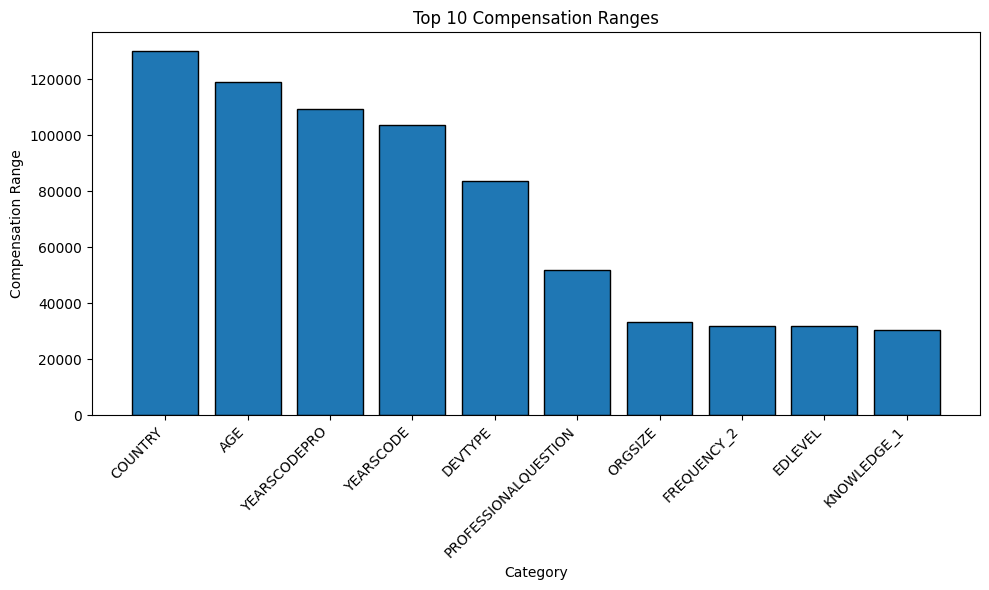

In [12]:
import matplotlib.pyplot as plt

top_10 = range_series.head(10)

plt.figure(figsize=(10, 6))
plt.bar(top_10.index, top_10.values, edgecolor='black')
plt.title("Top 10 Compensation Ranges")
plt.xlabel("Category")
plt.ylabel("Compensation Range")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


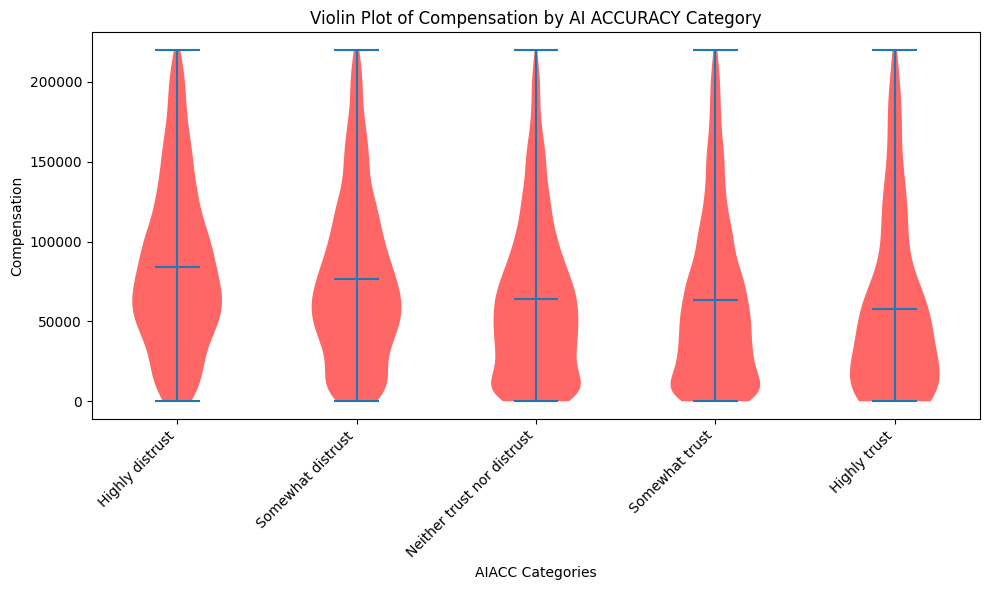

In [13]:
import matplotlib.pyplot as plt
import numpy as np

order = ["Highly distrust", "Somewhat distrust", "Neither trust nor distrust", "Somewhat trust", "Highly trust"]
data = [df_comp.loc[df_comp['AIACC'] == cat, 'CONVERTEDCOMPYEARLY'] for cat in order]

plt.figure(figsize=(10, 6))
ax = plt.gca()
parts = ax.violinplot(data, showmeans=True, showextrema=True)

# Color the violins red
for pc in parts['bodies']:
    pc.set_facecolor('red')
    pc.set_alpha(0.6)

plt.xticks(ticks=np.arange(1, len(order) + 1), labels=order, rotation=45, ha='right')
plt.xlabel("AIACC Categories")
plt.ylabel("Compensation")
plt.title("Violin Plot of Compensation by AI ACCURACY Category")
plt.tight_layout()
plt.show()


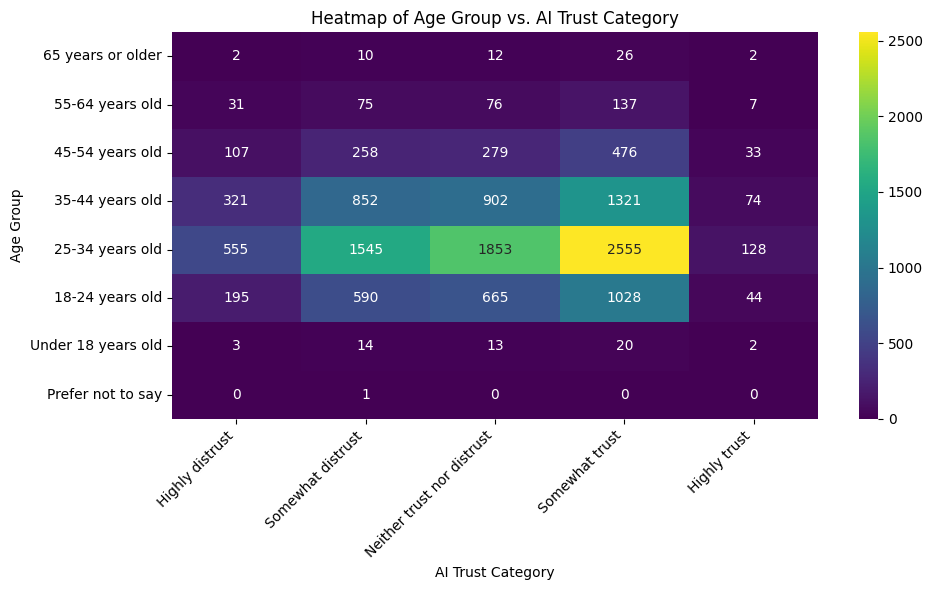

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define your custom orders
age_order = [
    "65 years or older",
    "55-64 years old",
    "45-54 years old",
    "35-44 years old",
    "25-34 years old",
    "18-24 years old",
    "Under 18 years old",
    "Prefer not to say"
]

trust_order = [
    "Highly distrust",
    "Somewhat distrust",
    "Neither trust nor distrust",
    "Somewhat trust",
    "Highly trust"
]


heatmap_data = df_comp.pivot_table(
    index="AGE",       
    columns="AIACC",   
    aggfunc="size",    
    fill_value=0
)

heatmap_data = heatmap_data.reindex(index=age_order)
heatmap_data = heatmap_data.reindex(columns=trust_order)

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="viridis")
plt.title("Heatmap of Age Group vs. AI Trust Category")
plt.xlabel("AI Trust Category")
plt.ylabel("Age Group")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [15]:
def clean_and_split(val):
    if isinstance(val, str):
        if ';' in val:
            val = val.lower()
            return [item.strip() for item in val.split(';')].sort()
        else:
            val = val.lower()
            return val.strip()
    return val
odf_2024 = odf_2024.applymap(clean_and_split)
combined_df = combined_df.applymap(clean_and_split)

C:\Users\tjabl\AppData\Local\Temp\ipykernel_4104\810499925.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  odf_2024 = odf_2024.applymap(clean_and_split)
C:\Users\tjabl\AppData\Local\Temp\ipykernel_4104\810499925.py:11: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  combined_df = combined_df.applymap(clean_and_split)


Total respondents per year:
 year
2022    4507
2023    5361
2024    3713
dtype: int64
   year LANGUAGEHAVEWORKEDWITH  count  normalized
0  2022                    apl     59    0.013091
1  2022               assembly      4    0.000888
2  2022             bash/shell     38    0.008431
3  2022                      c     79    0.017528
4  2022                     c#    541    0.120036
5  2022                    c++    187    0.041491
6  2022                clojure     70    0.015531
7  2022                   dart    105    0.023297
8  2022                 delphi    277    0.061460
9  2022                 elixir     44    0.009763
Top 10 Languages Overall:
 Index(['python', 'c#', 'java', 'javascript', 'delphi', 'c++', 'swift',
       'kotlin', 'php', 'go'],
      dtype='object', name='LANGUAGEHAVEWORKEDWITH')
Pivot Table:
 year                        2022      2023      2024
LANGUAGEHAVEWORKEDWITH                              
c#                      0.120036  0.121060  0.121734
c++      

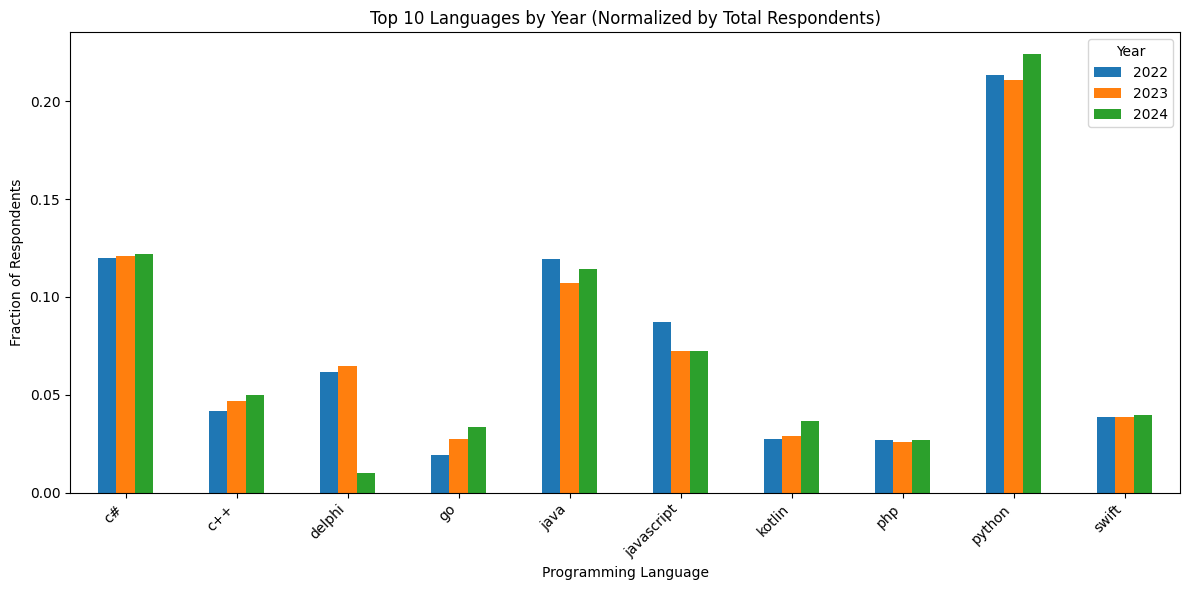

In [16]:
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def parse_language_list(lang_value):
    """
    Custom parser for the LANGUAGEHAVEWORKEDWITH column.
    Expects values in the form "[html/css, javascript, typescript]" (without quotes)
    and returns a list of lowercased languages.
    """
    if pd.isna(lang_value):
        return []
    if isinstance(lang_value, str):
        lang_value = lang_value.strip()
        if lang_value.startswith("[") and lang_value.endswith("]"):
            inner = lang_value[1:-1].strip()
            if not inner:
                return []
            # Split by comma and strip spaces and any extraneous quotes
            parts = inner.split(",")
            parts = [part.strip().strip("'").strip('"').lower() for part in parts if part.strip()]
            return parts
        else:
            parts = lang_value.split(",")
            parts = [part.strip().strip("'").strip('"').lower() for part in parts if part.strip()]
            return parts
    return []

df = combined_df.copy()

df['LANGUAGEHAVEWORKEDWITH'] = df['LANGUAGEHAVEWORKEDWITH'].apply(parse_language_list)


total_respondents = (
    df[df['LANGUAGEHAVEWORKEDWITH'].apply(lambda x: len(x) > 0)]
    .groupby('year')
    .size()
)
print("Total respondents per year:\n", total_respondents)


df_exploded = df.explode('LANGUAGEHAVEWORKEDWITH')

lang_counts = (
    df_exploded
    .groupby(['year', 'LANGUAGEHAVEWORKEDWITH'])
    .size()
    .reset_index(name='count')
)

lang_counts['normalized'] = lang_counts.apply(
    lambda row: row['count'] / total_respondents[row['year']], axis=1
)

print(lang_counts.head(10))

top_10_langs_overall = (
    lang_counts
    .groupby('LANGUAGEHAVEWORKEDWITH')['count']
    .sum()
    .sort_values(ascending=False)
    .head(10)
    .index
)
print("Top 10 Languages Overall:\n", top_10_langs_overall)

top_lang_counts = lang_counts[lang_counts['LANGUAGEHAVEWORKEDWITH'].isin(top_10_langs_overall)]

pivot_df = (
    top_lang_counts
    .pivot(index='LANGUAGEHAVEWORKEDWITH', columns='year', values='normalized')
    .fillna(0)
)
print("Pivot Table:\n", pivot_df)

plt.figure(figsize=(12, 6))
pivot_df.plot(kind='bar', ax=plt.gca())
plt.title("Top 10 Languages by Year (Normalized by Total Respondents)")
plt.xlabel("Programming Language")
plt.ylabel("Fraction of Respondents")
plt.legend(title="Year")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [17]:
df.describe(include='all')

,KNOWLEDGE_7,PROFESSIONALTECH,SOVISITFREQ,OFFICESTACKSYNCWANTTOWORKWITH,CODINGACTIVITIES,DEVTYPE,SOACCOUNT,TOOLSTECHHAVEWORKEDWITH,NEWSOSITES,SOPARTFREQ,...,ICORPM,OPSYSPERSONALUSE,MAINBRANCH,DATABASEHAVEWORKEDWITH,KNOWLEDGE_3,WEBFRAMEHAVEWORKEDWITH,NEWCOLLABTOOLSHAVEWORKEDWITH,COUNTRY,TIMESEARCHING,year
count,104222,22358,217637,59433,87287,160358,218984,32889,66619,169527,...,109752,107897,227889,48852,105026,36390,39021,218674,107887,227889.000000
unique,5,10,5,23,8,35,3,54,7,6,...,3,20,7,36,5,40,41,194,5,NaN
top,agree,none of these,a few times per week,slack,hobby,"developer, full-stack",yes,npm,stack overflow,less than once per month or monthly,...,individual contributor,windows,i am a developer by profession,postgresql,agree,node.js,visual studio code,united states of america,30-60 minutes a day,NaN
freq,39018,12363,67093,19122,43419,51137,170254,9395,62340,85669,...,63573,50855,170951,11085,42623,3866,21661,43285,40941,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022.965637
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.779406
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2023.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024.000000


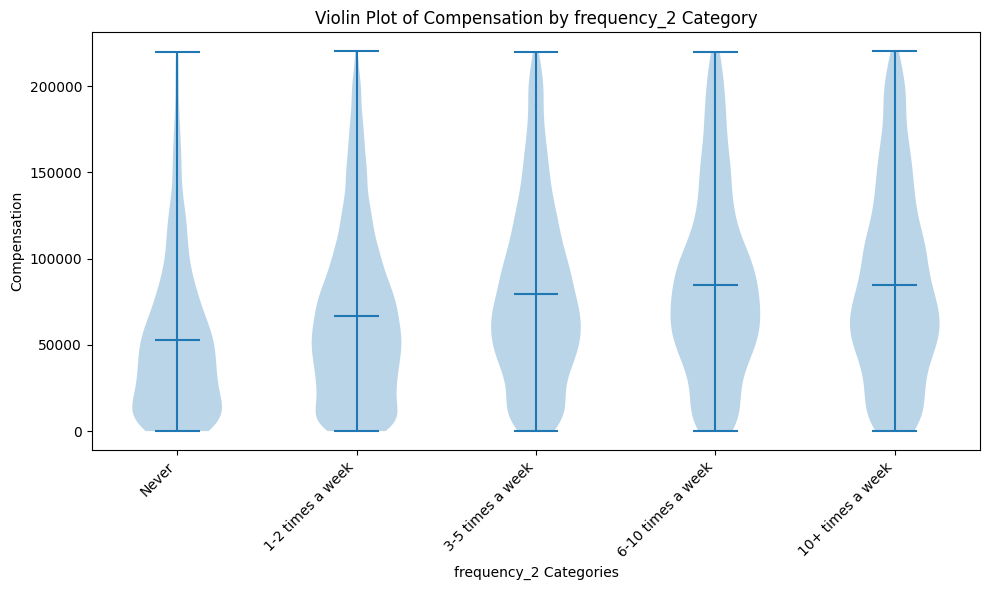

In [18]:
import matplotlib.pyplot as plt
import numpy as np

desired_order = ["Never", "1-2 times a week", "3-5 times a week", 
                 "6-10 times a week", "10+ times a week"]
  
data = [df_comp.loc[df_comp['FREQUENCY_2'] == cat, 'CONVERTEDCOMPYEARLY'] 
        for cat in desired_order]

plt.figure(figsize=(10, 6))
plt.violinplot(data, showmeans=True)

plt.xticks(ticks=np.arange(1, len(desired_order) + 1),
           labels=desired_order, rotation=45, ha='right')
plt.xlabel("frequency_2 Categories")
plt.ylabel("Compensation")
plt.title("Violin Plot of Compensation by frequency_2 Category")
plt.tight_layout()
plt.show()


C:\Users\tjabl\AppData\Local\Temp\ipykernel_4104\3813776779.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top5 = avg_priority.groupby('ORGSIZE').apply(lambda df: df.nlargest(5, 'Importance')).reset_index(drop=True)


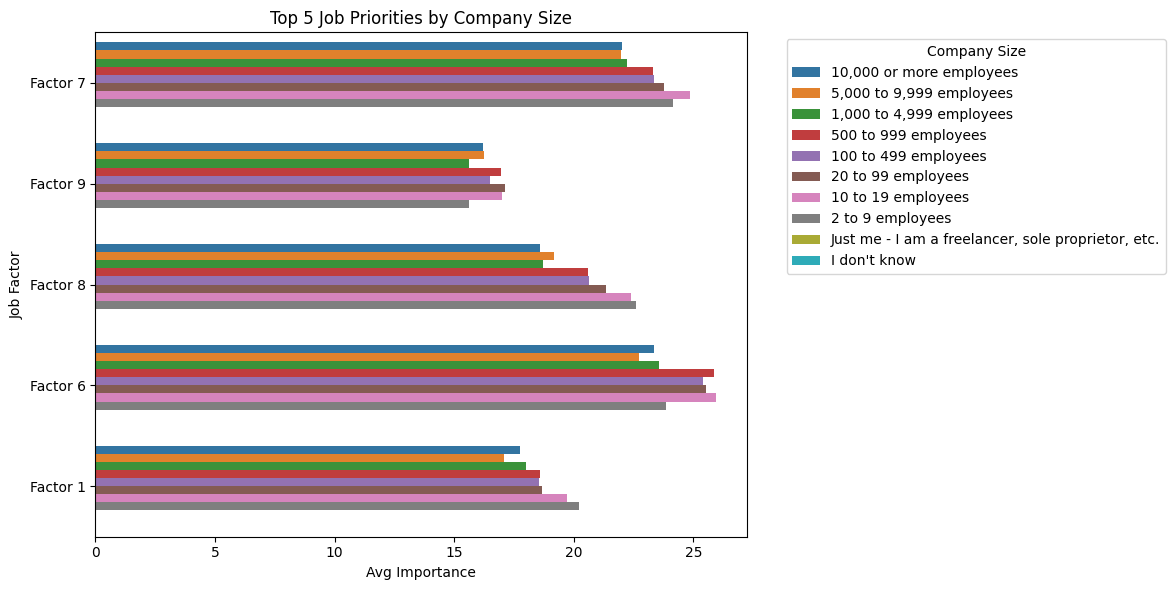

In [19]:
priority_cols = [col for col in odf_2024.columns if col.startswith('JOBSATPOINTS_')]
priority_df = odf_2024[['ORGSIZE'] + priority_cols].dropna()

priority_df = priority_df.melt(id_vars='ORGSIZE', value_vars=priority_cols,
                               var_name='Priority', value_name='Importance')

avg_priority = priority_df.groupby(['ORGSIZE', 'Priority'])['Importance'].mean().reset_index()
avg_priority['Priority'] = avg_priority['Priority'].str.replace('JOBSATPOINTS_', 'Factor ')

top5 = avg_priority.groupby('ORGSIZE').apply(lambda df: df.nlargest(5, 'Importance')).reset_index(drop=True)

size_order = [
    '10,000 or more employees',
    '5,000 to 9,999 employees',
    '1,000 to 4,999 employees',
    '500 to 999 employees',
    '100 to 499 employees',
    '20 to 99 employees',
    '10 to 19 employees',
    '2 to 9 employees',
    'Just me - I am a freelancer, sole proprietor, etc.',
    "I don't know"
]

top5['ORGSIZE'] = pd.Categorical(top5['ORGSIZE'], categories=size_order, ordered=True)
top5 = top5.sort_values('ORGSIZE', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(data=top5, x='Importance', y='Priority', hue='ORGSIZE', hue_order=size_order)

plt.title('Top 5 Job Priorities by Company Size')
plt.xlabel('Avg Importance')
plt.ylabel('Job Factor')
plt.legend(title='Company Size', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

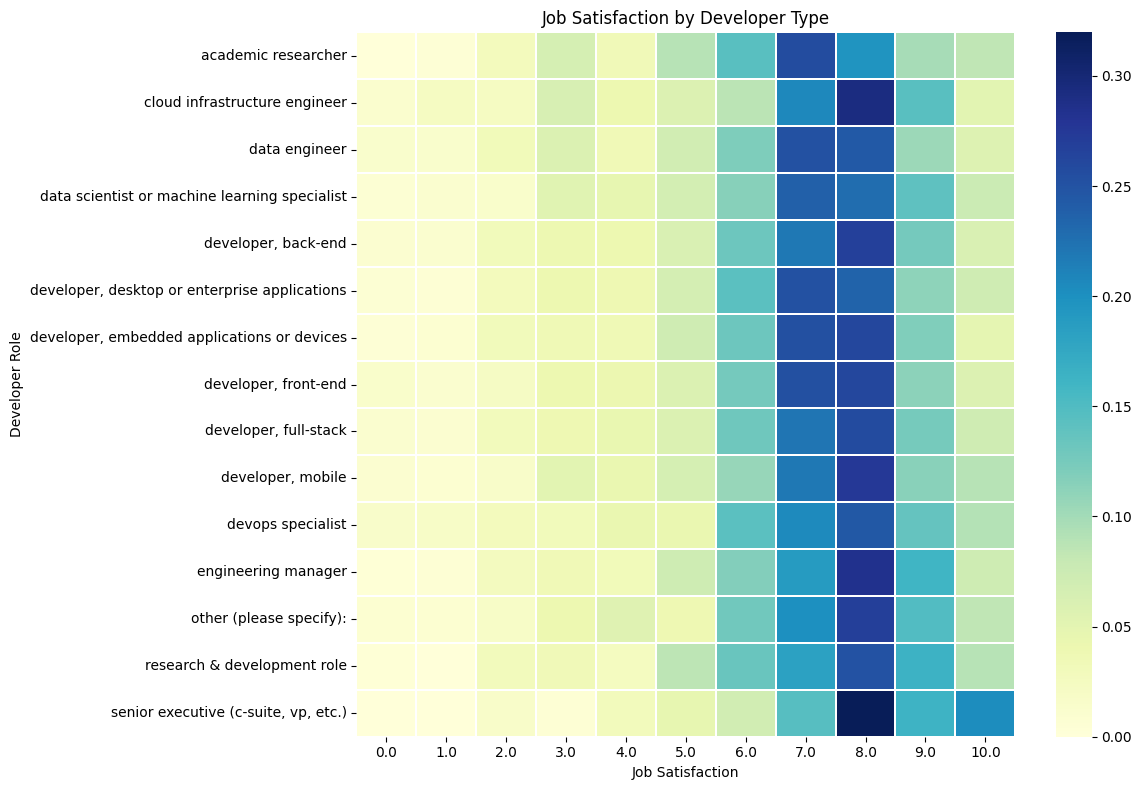

In [20]:
salary_q_low = odf_2024['CONVERTEDCOMPYEARLY'].quantile(0.025)
salary_q_high = odf_2024['CONVERTEDCOMPYEARLY'].quantile(0.975)

valid_countries = odf_2024['COUNTRY'].value_counts()[lambda x: x >= 50].index

filtered_df = odf_2024[
    (odf_2024['CONVERTEDCOMPYEARLY'] >= salary_q_low) &
    (odf_2024['CONVERTEDCOMPYEARLY'] <= salary_q_high) &
    (odf_2024['COUNTRY'].isin(valid_countries))
]

dev_sat = filtered_df.groupby('DEVTYPE')['JOBSAT'].value_counts(normalize=True).unstack().fillna(0)

top_devtypes = filtered_df['DEVTYPE'].value_counts().head(15).index
dev_sat = dev_sat.loc[dev_sat.index.intersection(top_devtypes)]

plt.figure(figsize=(12, 8))
sns.heatmap(dev_sat, cmap='YlGnBu', annot=False, linewidths=0.3)
plt.title('Job Satisfaction by Developer Type')
plt.xlabel('Job Satisfaction')
plt.ylabel('Developer Role')
plt.tight_layout()

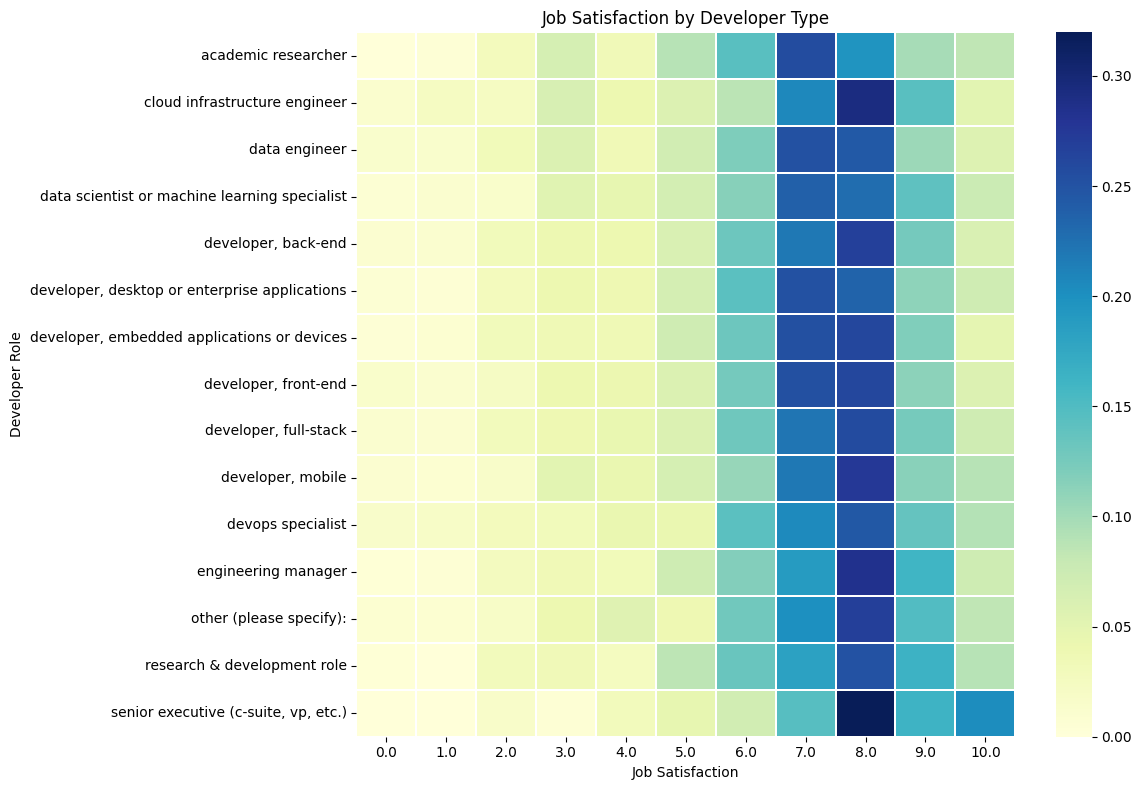

In [21]:
salary_q_low = odf_2024['CONVERTEDCOMPYEARLY'].quantile(0.025)
salary_q_high = odf_2024['CONVERTEDCOMPYEARLY'].quantile(0.975)

valid_countries = odf_2024['COUNTRY'].value_counts()[lambda x: x >= 50].index

filtered_df = odf_2024[
    (odf_2024['CONVERTEDCOMPYEARLY'] >= salary_q_low) &
    (odf_2024['CONVERTEDCOMPYEARLY'] <= salary_q_high) &
    (odf_2024['COUNTRY'].isin(valid_countries))
]

dev_sat = filtered_df.groupby('DEVTYPE')['JOBSAT'].value_counts(normalize=True).unstack().fillna(0)

top_devtypes = filtered_df['DEVTYPE'].value_counts().head(15).index
dev_sat = dev_sat.loc[dev_sat.index.intersection(top_devtypes)]

plt.figure(figsize=(12, 8))
sns.heatmap(dev_sat, cmap='YlGnBu', annot=False, linewidths=0.3)
plt.title('Job Satisfaction by Developer Type')
plt.xlabel('Job Satisfaction')
plt.ylabel('Developer Role')
plt.tight_layout()

C:\Users\tjabl\AppData\Local\Temp\ipykernel_4104\2798457858.py:63: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("viridis")


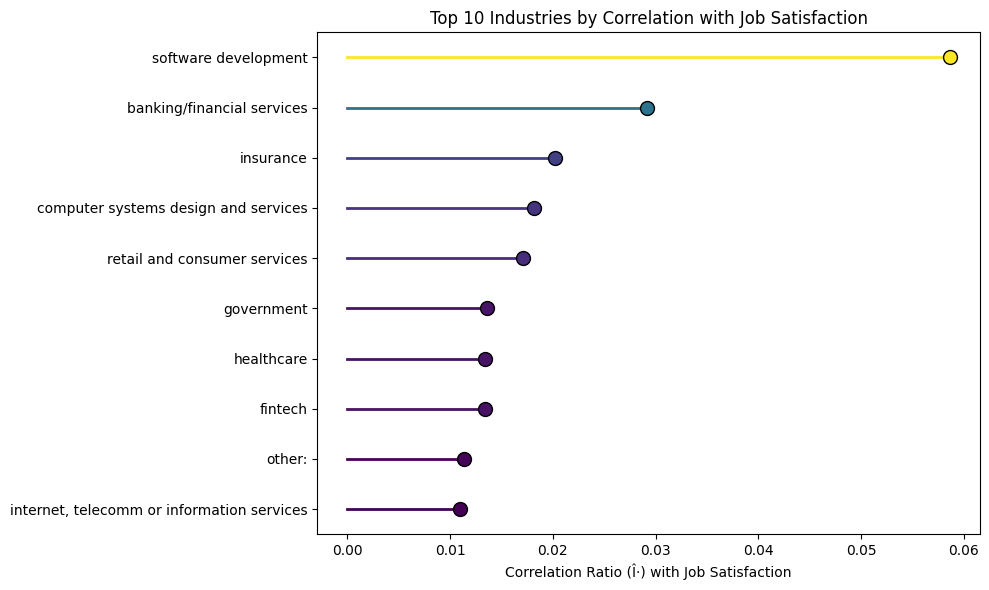

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.colors as mcolors
import matplotlib.cm as cm

def correlation_ratio(categories, values):
    """
    Calculate the correlation ratio (eta) for a categorical (categories)
    and a numeric (values) variable.
    """
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat) + 1

    if cat_num < 2 or len(values) == 0:
        return np.nan
    
    y_mean = np.nanmean(values)
    ss_between = 0.0
    ss_total = np.nansum((values - y_mean) ** 2)
    
    for i in range(cat_num):
        group_vals = values[fcat == i]
        if len(group_vals) == 0:
            continue
        group_mean = np.nanmean(group_vals)
        ss_between += len(group_vals) * (group_mean - y_mean) ** 2
    
    if ss_total == 0:
        return np.nan
    return np.sqrt(ss_between / ss_total)


df_ind = odf_2024[['INDUSTRY', 'JOBSAT']].dropna(subset=['JOBSAT']).copy()

df_ind['INDUSTRY'] = df_ind['INDUSTRY'].fillna('').astype(str)
df_ind['INDUSTRY_LIST'] = df_ind['INDUSTRY'].apply(
    lambda x: [item.strip() for item in x.split(';') if item.strip() != '']
)

mlb = MultiLabelBinarizer()
encoded_data = mlb.fit_transform(df_ind['INDUSTRY_LIST'])
encoded_cols = mlb.classes_

df_encoded = pd.DataFrame(encoded_data, columns=encoded_cols, index=df_ind.index)
df_ind = pd.concat([df_ind, df_encoded], axis=1)

industry_corrs = {}
for ind_col in encoded_cols:
    if df_ind[ind_col].sum() > 0:
        raw_corr = correlation_ratio(df_ind[ind_col].values, df_ind['JOBSAT'].values)
        if not pd.isna(raw_corr):
            industry_corrs[ind_col] = raw_corr


industry_corrs_series = pd.Series(industry_corrs).sort_values(ascending=False)
top_10_industry = industry_corrs_series.head(10)

plt.figure(figsize=(10, 6))


cmap = cm.get_cmap("viridis")
norm = mcolors.Normalize(vmin=top_10_industry.min(), vmax=top_10_industry.max())

y_positions = np.arange(len(top_10_industry))

for i, (industry, corr_val) in enumerate(top_10_industry.items()):
    color = cmap(norm(corr_val)) 
    plt.plot([0, corr_val], [i, i], color=color, linewidth=2)
    plt.scatter(corr_val, i, color=color, s=100, edgecolor='black', zorder=3)

plt.yticks(y_positions, top_10_industry.index)
plt.ylim(-0.5, len(top_10_industry) - 0.5)
plt.gca().invert_yaxis()  # highest correlation at the top

plt.xlabel("Correlation Ratio (Î·) with Job Satisfaction")
plt.title("Top 10 Industries by Correlation with Job Satisfaction")

plt.tight_layout()
plt.show()

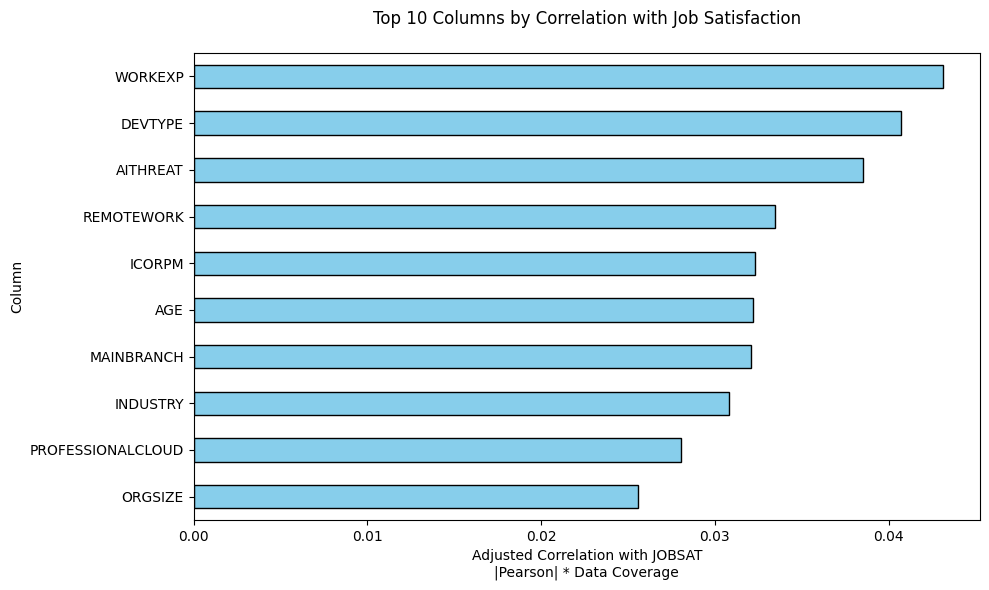

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def correlation_ratio(categories, values):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat) + 1
    
    if cat_num < 2 or len(values) == 0:
        return np.nan
    
    y_mean = np.nanmean(values)
    
    ss_between = 0.0
    ss_total = 0.0
    
    for i in range(cat_num):
        cat_values = values[fcat == i]
        if len(cat_values) == 0:
            continue
        cat_mean = np.nanmean(cat_values)
        ss_between += len(cat_values) * (cat_mean - y_mean) ** 2
    
    ss_total = np.nansum((values - y_mean) ** 2)

    if ss_total == 0:
        return np.nan
    return np.sqrt(ss_between / ss_total)

corr_values = {}
total_rows = len(odf_2024)

for col in odf_2024.columns:
    if col == 'JOBSAT':
        continue
    if col.startswith('JOBSATPOINTS_'):
        continue
    
    odf_2024_cleaned = odf_2024[[col, 'JOBSAT']].dropna()
    if odf_2024_cleaned.empty:
        continue
    
    if odf_2024_cleaned[col].nunique() <= 1:
        continue
    
    fraction_of_data = len(odf_2024_cleaned) / total_rows
    
    if pd.api.types.is_numeric_dtype(odf_2024_cleaned[col]):
        raw_corr = odf_2024_cleaned[col].corr(odf_2024_cleaned['JOBSAT'], method='pearson')
        if pd.isna(raw_corr):
            continue
        adjusted_corr = abs(raw_corr) * fraction_of_data
    else:
        cat_values = odf_2024_cleaned[col].values
        job_values = odf_2024_cleaned['JOBSAT'].values
        raw_corr = correlation_ratio(cat_values, job_values)
        if pd.isna(raw_corr):
            continue
        adjusted_corr = raw_corr * fraction_of_data
    
    corr_values[col] = adjusted_corr

all_corr = pd.Series(corr_values).sort_values(ascending=False)

next_10_corr = all_corr.iloc[10:20]

if next_10_corr.empty:
    print("No columns found in the 11th to 20th rank after filtering.")
else:
    plt.figure(figsize=(10, 6))
    next_10_corr.plot(kind='barh', color='skyblue', edgecolor='black')
    plt.xlabel("Adjusted Correlation with JOBSAT\n|Pearson| * Data Coverage")
    plt.ylabel("Column")
    plt.title("Top 10 Columns by Correlation with Job Satisfaction\n")
    plt.gca().invert_yaxis() 
    plt.tight_layout()
    plt.show()